Using Device: cpu
Parsing ClinVar VCF...


4128559it [00:25, 158849.38it/s]


Data Split: 1963 Training variants, 347 Test variants.
Extracting sequences...


2025-12-08 05:50:15.974860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-08 05:50:16.291633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-08 05:50:16.372755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-08 05:50:17.009360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at InstaDeepAI/n

Starting Training (3 Epochs)...


Epoch 1: 100%|██████████| 246/246 [2:53:31<00:00, 42.32s/it]  


Epoch 1 Average Loss: 0.6541


Epoch 2: 100%|██████████| 246/246 [2:53:11<00:00, 42.24s/it]  


Epoch 2 Average Loss: 0.4564


Epoch 3: 100%|██████████| 246/246 [2:54:02<00:00, 42.45s/it]  


Epoch 3 Average Loss: 0.2151
Saving Model...


Copying file://trained_asd_model.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][885.0 MiB/885.0 MiB]    1.4 MiB/s                                   
Operation completed over 1 objects/885.0 MiB.                                    



Running Evaluation on Test Set...


Evaluating: 100%|██████████| 22/22 [09:54<00:00, 27.03s/it]



Evaluation Report:
              precision    recall  f1-score   support

      Benign       0.75      0.71      0.73       174
  Pathogenic       0.72      0.76      0.74       173

    accuracy                           0.73       347
   macro avg       0.74      0.73      0.73       347
weighted avg       0.74      0.73      0.73       347



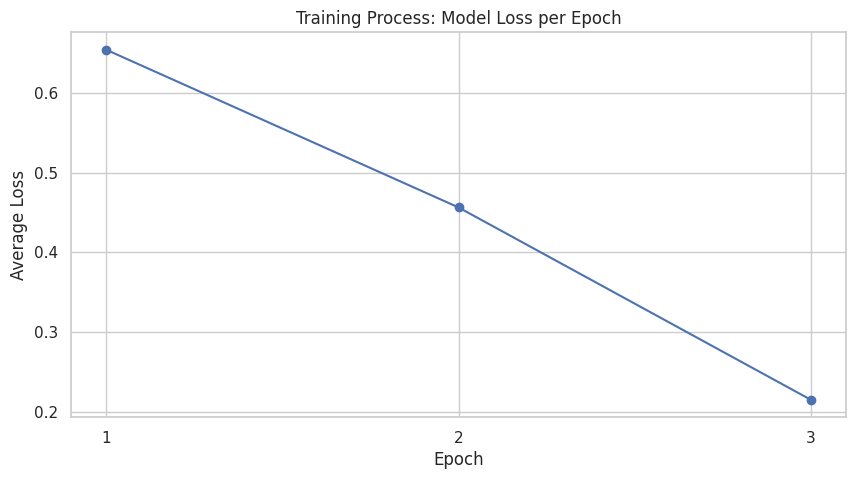

Copying file://training_loss_curve.png [Content-Type=image/png]...
/ [1 files][ 31.5 KiB/ 31.5 KiB]                                                
Operation completed over 1 objects/31.5 KiB.                                     


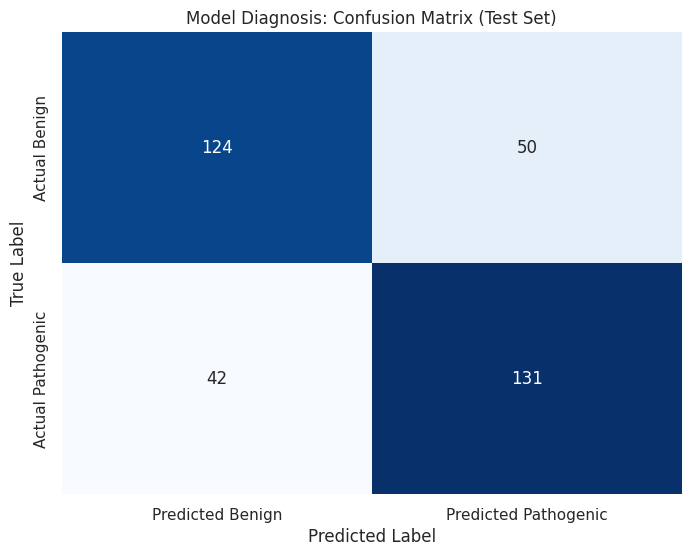

Copying file://model_confusion_matrix.png [Content-Type=image/png]...
/ [1 files][ 26.7 KiB/ 26.7 KiB]                                                
Operation completed over 1 objects/26.7 KiB.                                     



✓ Plots saved to gs://fc-secure-b8cbf1c7-c51b-44be-b4f7-4f88082bda65/results/


In [1]:
# train initial model again in the All of Us environment
import os
import pysam
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

sns.set_theme(style="whitegrid")

bucket = os.getenv("WORKSPACE_BUCKET")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

if not os.path.exists("clinvar.vcf.gz"):
    print("Downloading ClinVar...")
    os.system("wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz")
    os.system("wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz.tbi")

ref_path = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
if not os.path.exists(ref_path):
    print("Downloading Reference Genome...")
    os.system(f"wget -q https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/{ref_path}.gz")
    os.system(f"gunzip -f {ref_path}.gz")
    os.system(f"samtools faidx {ref_path}")

print("Parsing ClinVar VCF...")
vcf = pysam.VariantFile("clinvar.vcf.gz")
ref_fa = pysam.FastaFile(ref_path)
asd_keywords = ["autism", "autistic", "autism spectrum"]
rows = []

for record in tqdm(vcf):
    if "CLNSIG" not in record.info or "CLNDN" not in record.info: continue
    clnsig = ",".join(record.info["CLNSIG"]).lower()
    clndn = ",".join(record.info["CLNDN"]).lower()
    
    if "pathogenic" in clnsig and "benign" not in clnsig:
        if any(k in clndn for k in asd_keywords):
            rows.append([record.chrom, record.pos, 1])
    elif "benign" in clnsig and "pathogenic" not in clnsig:
        rows.append([record.chrom, record.pos, 0])

df = pd.DataFrame(rows, columns=["chrom", "pos", "label"])
pos_df = df[df.label == 1]
neg_df = df[df.label == 0]

if len(neg_df) > len(pos_df):
    neg_df = neg_df.sample(n=len(pos_df), random_state=42)

balanced_df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)

train_df, test_df = train_test_split(balanced_df, test_size=0.15, random_state=42, stratify=balanced_df['label'])
print(f"Data Split: {len(train_df)} Training variants, {len(test_df)} Test variants.")

def get_seq(chrom, pos, window=512):
    chrom = str(chrom)
    target = chrom if chrom in ref_fa.references else chrom.replace("chr","") if chrom.startswith("chr") else f"chr{chrom}"
    if target not in ref_fa.references: return "N"*window
    start = max(0, int(pos) - 1 - (window//2))
    end = start + window
    return ref_fa.fetch(target, start, end).upper()

print("Extracting sequences...")
train_df['seq'] = train_df.apply(lambda x: get_seq(x.chrom, x.pos), axis=1)
test_df['seq'] = test_df.apply(lambda x: get_seq(x.chrom, x.pos), axis=1)


model_name = "InstaDeepAI/nucleotide-transformer-v2-250m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, trust_remote_code=True)
model.to(device)

class DNADataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df['seq'].tolist(), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        self.labels = torch.tensor(df['label'].tolist())
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_loader = DataLoader(DNADataset(train_df), batch_size=8, shuffle=True)
test_loader = DataLoader(DNADataset(test_df), batch_size=16, shuffle=False)
optim = AdamW(model.parameters(), lr=2e-5)

print("Starting Training (3 Epochs)...")
model.train()
train_losses = [] 

for epoch in range(3):
    total_loss = 0
    for batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

print("Saving Model...")
torch.save(model.state_dict(), "trained_asd_model.pth")
os.system(f"gsutil cp trained_asd_model.pth {bucket}/data/trained_asd_model.pth")

print("\nRunning Evaluation on Test Set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch, labels in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask=mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nEvaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Benign", "Pathogenic"]))

# --- PLOT 1: TRAINING PROCESS (Loss Curve) ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Process: Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks([1, 2, 3])
plt.savefig("training_loss_curve.png")
plt.show() # Show in notebook
os.system(f"gsutil cp training_loss_curve.png {bucket}/results/")

# --- PLOT 2: DIAGNOSIS (Confusion Matrix) ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Benign", "Predicted Pathogenic"],
            yticklabels=["Actual Benign", "Actual Pathogenic"])
plt.title('Model Diagnosis: Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("model_confusion_matrix.png")
plt.show() # Show in notebook
os.system(f"gsutil cp model_confusion_matrix.png {bucket}/results/")

print(f"\n✓ Plots saved to {bucket}/results/")

In [9]:
# patient-level score per person

# transfer-learning again here
import os
import pysam
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

bucket = os.getenv("WORKSPACE_BUCKET")
device = "cuda" if torch.cuda.is_available() else "cpu"


print("Copying Patient Data from Bucket...")
os.system(f"gsutil cp {bucket}/data/aou_sfari_variants_fast.csv .")
os.system(f"gsutil cp {bucket}/data/aou_sfari_genotypes_long.csv .")
os.system(f"gsutil cp {bucket}/data/trained_asd_model.pth .")


Copying Patient Data from Bucket...


Copying gs://fc-secure-b8cbf1c7-c51b-44be-b4f7-4f88082bda65/data/aou_sfari_variants_fast.csv...
- [1 files][300.4 MiB/300.4 MiB]                                                
Operation completed over 1 objects/300.4 MiB.                                    
Copying gs://fc-secure-b8cbf1c7-c51b-44be-b4f7-4f88082bda65/data/aou_sfari_genotypes_long.csv...
| [1 files][  3.0 GiB/  3.0 GiB]   51.1 MiB/s                                   
Operation completed over 1 objects/3.0 GiB.                                      
Copying gs://fc-secure-b8cbf1c7-c51b-44be-b4f7-4f88082bda65/data/trained_asd_model.pth...
/ [1 files][885.0 MiB/885.0 MiB]   54.9 MiB/s                                   
Operation completed over 1 objects/885.0 MiB.                                    


0

In [ ]:
variants_df = pd.read_csv("aou_sfari_variants_fast.csv")
genotypes_df = pd.read_csv("aou_sfari_genotypes_long.csv")

print(f"Loaded {len(variants_df)} variants and {len(genotypes_df)} genotype records.")

In [ ]:
# 2. PREPARE SEQUENCES
# --------------------
# Ensure ref genome is available (reuse from step 1 if file exists)
ref_path = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
ref_fa = pysam.FastaFile(ref_path)

def get_patient_seq(chrom, pos, ref, alt, window=512):
    chrom = str(chrom)
    target = chrom if chrom in ref_fa.references else chrom.replace("chr","") if chrom.startswith("chr") else f"chr{chrom}"
    if target not in ref_fa.references: return "N"*window
    
    start = max(0, int(pos) - 1 - (window//2))
    end = start + window
    seq = ref_fa.fetch(target, start, end).upper()
    
    # Inject Mutation (Simple SNP handling)
    mid = window // 2
    if len(ref) == 1 and len(alt) == 1 and mid < len(seq):
        seq_list = list(seq)
        seq_list[mid] = alt 
        seq = "".join(seq_list)
    return seq

print("Extracting sequences for patient variants...")
variants_df['seq'] = variants_df.apply(lambda x: get_patient_seq(x.Chrom, x.Pos, x.Ref, x.Alt), axis=1)


In [12]:
# 3. LOAD MODEL & INFERENCE
# --------------------
model_name = "InstaDeepAI/nucleotide-transformer-v2-250m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, trust_remote_code=True)

# Load the weights we trained in Task 1
model.load_state_dict(torch.load("trained_asd_model.pth", map_location=device))
model.to(device)
model.eval()

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-250m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-250m-multi-species and are newly initialized: ['classifier.dense.bias', 

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 768, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 768, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-23): 24 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import pysam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

bucket = os.getenv("WORKSPACE_BUCKET")
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu_count = torch.cuda.device_count()

print(f"🚀 HARDWARE STATUS: {device} | GPUs: {gpu_count}")
if gpu_count < 4:
    print("⚠️ Warning: Less than 4 GPUs detected, but we will use what we have.")

print("\nLoading Data from Bucket...")
if not os.path.exists("aou_sfari_variants_fast.csv"):
    os.system(f"gsutil cp {bucket}/data/aou_sfari_variants_fast.csv .")
    os.system(f"gsutil cp {bucket}/data/aou_sfari_genotypes_long.csv .")
    os.system(f"gsutil cp {bucket}/data/trained_asd_model.pth .")

variants_df = pd.read_csv("aou_sfari_variants_fast.csv")
genotypes_df = pd.read_csv("aou_sfari_genotypes_long.csv")


print(f"Original Variants: {len(variants_df)}")

variants_df['Var_ID'] = variants_df['Chrom'].astype(str) + ":" + \
                        variants_df['Pos'].astype(str) + "_" + \
                        variants_df['Ref'] + ">" + variants_df['Alt']

relevant_genotypes = genotypes_df[genotypes_df['GT_num'] > 0]
relevant_var_ids = set(relevant_genotypes['Var_ID'].unique())

subset_variants_df = variants_df[variants_df['Var_ID'].isin(relevant_var_ids)].copy()
subset_variants_df = subset_variants_df.drop_duplicates(subset=['Var_ID'])

print(f"✓ Filtered to {len(subset_variants_df)} relevant variants (present in patients).")

ref_path = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
if not os.path.exists(ref_path):
    print("Downloading Reference Genome...")
    os.system(f"wget -q https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/{ref_path}.gz")
    os.system(f"gunzip -f {ref_path}.gz")
    os.system(f"samtools faidx {ref_path}")

ref_fa = pysam.FastaFile(ref_path)

def get_seq(chrom, pos, ref, alt, window=512):
    chrom = str(chrom)
    target = chrom if chrom in ref_fa.references else chrom.replace("chr","") if chrom.startswith("chr") else f"chr{chrom}"
    if target not in ref_fa.references: return "N"*window
    
    start = max(0, int(pos) - 1 - (window//2))
    end = start + window
    seq = ref_fa.fetch(target, start, end).upper()
    
    mid = window // 2
    if len(ref) == 1 and len(alt) == 1 and mid < len(seq):
        seq_list = list(seq)
        seq_list[mid] = alt 
        seq = "".join(seq_list)
    return seq

print("Extracting sequences...")
subset_variants_df['seq'] = subset_variants_df.apply(lambda x: get_seq(x.Chrom, x.Pos, x.Ref, x.Alt), axis=1)

model_name = "InstaDeepAI/nucleotide-transformer-v2-250m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, trust_remote_code=True)

if os.path.exists("trained_asd_model.pth"):
    model.load_state_dict(torch.load("trained_asd_model.pth", map_location=device))
    print("✓ Loaded trained model weights.")

model.to(device)
if gpu_count > 1:
    model = nn.DataParallel(model) # <--- ENABLE ALL 4 GPUS

model.eval()
class InferenceDataset(Dataset):
    def __init__(self, sequences):
        self.encodings = tokenizer(sequences, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    def __len__(self): return len(self.encodings.input_ids)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

loader = DataLoader(InferenceDataset(subset_variants_df['seq'].tolist()), batch_size=128, shuffle=False, num_workers=2)

probs = []
print("Starting High-Speed Inference...")
with torch.no_grad():
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=mask)
        scores = torch.softmax(outputs.logits, dim=1)[:, 1]
        probs.extend(scores.cpu().numpy())

subset_variants_df['risk_score'] = probs

print("Calculating Final Scores...")
merged = genotypes_df.merge(subset_variants_df[['Var_ID', 'risk_score']], on='Var_ID', how='inner')
merged = merged[merged['GT_num'] > 0]
merged['burden'] = merged['GT_num'] * merged['risk_score']

final_scores = merged.groupby('Sample_ID')['burden'].sum().reset_index()
final_scores.columns = ['Person_ID', 'ASD_Polygenic_Score']

print("\n" + "="*30)
print("FINAL PATIENT RESULTS")
print("="*30)
print(final_scores.sort_values(by='ASD_Polygenic_Score', ascending=False))

final_scores.to_csv("final_patient_results.csv", index=False)
os.system(f"gsutil cp final_patient_results.csv {bucket}/results/")

🚀 HARDWARE STATUS: cuda | GPUs: 4

Loading Data from Bucket...
Original Variants: 5171400
✓ Filtered to 22482 relevant variants (present in patients).
Extracting sequences...


2025-12-08 20:36:53.564490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-08 20:36:53.882415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-08 20:36:53.974577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-08 20:36:54.603668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at InstaDeepAI/n

✓ Loaded trained model weights.
Starting High-Speed Inference...


100%|██████████| 176/176 [10:39<00:00,  3.63s/it]


Calculating Final Scores...

FINAL PATIENT RESULTS
   Person_ID  ASD_Polygenic_Score
3    2094952          3486.259990
4    3106478          3028.586190
0    1697536          3026.468140
1    1828915          3022.976016
8    5980826          3020.191936
6    5102217          2995.633698
7    5488546          2932.214166
2    2043335          2927.631192
5    3362261          2906.591230
9    9732008          2880.639945


Copying file://final_patient_results.csv [Content-Type=text/csv]...
/ [1 files][  296.0 B/  296.0 B]                                                
Operation completed over 1 objects/296.0 B.                                      


0

Original Patient Count: 10
Count after removing Outlier 2094952: 9


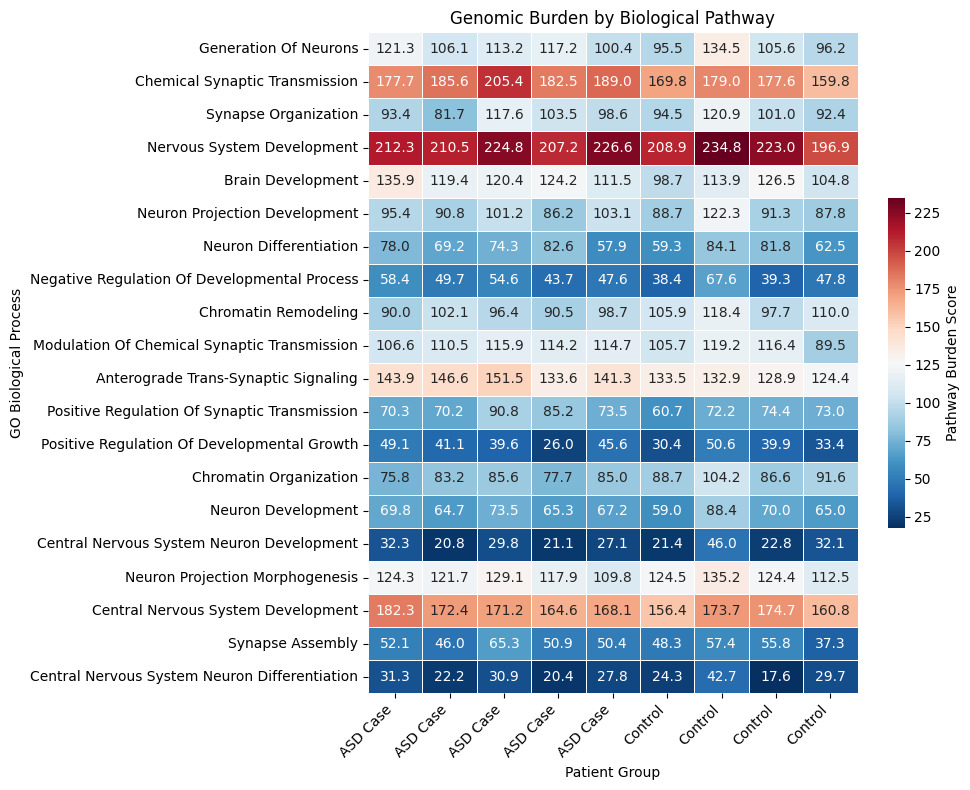

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SETUP & LOAD DATA
bucket = os.getenv("WORKSPACE_BUCKET")


if not os.path.exists("final_pathway_scores.csv"):
    os.system(f"gsutil cp {bucket}/results/final_pathway_scores.csv .")
res_df = pd.read_csv("final_pathway_scores.csv")

matrix = res_df.pivot_table(index='Pathway', columns='Person_ID', values='Score', fill_value=0)
matrix.columns = matrix.columns.astype(str) # Force string columns

top_var = matrix.var(axis=1).sort_values(ascending=False).head(20).index
matrix_top = matrix.loc[top_var]


# 4. SORT & PLOT
current_ids = matrix_top.columns.tolist()
ordered_cols = sorted(current_ids, key=lambda x: status_map.get(str(x), 'Unknown'))
matrix_top = matrix_top[ordered_cols]
x_labels = [status_map.get(pid, pid) for pid in ordered_cols]

plt.figure(figsize=(10, 8))
sns.heatmap(
    matrix_top,
    cmap="RdBu_r",         
    annot = True, 
    fmt=".1f", 
    linewidths=.5,
    xticklabels=x_labels,  
    cbar_kws={"shrink": 0.5, "label": "Pathway Burden Score"}
)

plt.title("Genomic Burden by Biological Pathway")
plt.xlabel("Patient Group")
plt.ylabel("GO Biological Process")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

$$\text{per-person burden score} = \sum (\text{genotype count} \times \text{model predicted risk})$$